## Settings

In [1]:
import sys
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy/")

#NumCosmo
from numcosmo_py import Ncm, Nc, GObject
from richness_mass_calib import create_richness_mass_calib

#Functions
#from Configs_Ascaso_Ext_Analysis import Binningf

#Useful packages
import numpy as np
import math
from scipy import stats

from astropy.io import fits
from astropy.table import Table
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from matplotlib.gridspec import GridSpec

%matplotlib inline

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

## Data

In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

print(f'{min(dt_halos["m200c"]):e}')

1.000236e+13


## Training and test sets

In [3]:
X = pd.DataFrame({'m200c': list(dt_halos["m200c"]), 'redshift_true': list(dt_halos["redshift_true"])})
y = pd.DataFrame({'richness': list(dt_halos["richness"])})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

#Training data
data_train = pd.concat([X_train, y_train], axis=1)

#Test  data
data_test = pd.concat([X_test, y_test], axis=1)

# print( data_test.shape, X_test.shape, y_test.shape )
# print( data_train.shape, X_train.shape, y_train.shape )

# print( data_test.shape[0] + data_train.shape[0] )

# print( len(dt_halos) )

## Bins

Nestas células fazemos um recorte de intervalos de z de largura 0.05 e esses intervalos são colocados em **halos_bin_z**. Depois, pegamos cada *bin* em z e cortamos em intervalos de lnM de largura 0.25. Os bins são colocados em **halos_bin_mz**.

Para cada intervalo em **halos_bin_mz** é calculado lnR médio, z médio e lnM médio e as listas desses valores são colocadas na tabela **halos_mean**.

In [4]:
# redshift bins
def Binningf(data_set):
    
    z_ds = data_set["redshift_true"]
    lnm_ds = np.log(data_set["m200c"])
    
    d = 0.05
    d_m = 0.25
    
    z_bins = int((max(z_ds) - min (z_ds)) // d  + 1)
    m_bins = int((max(lnm_ds) - min (lnm_ds)) // d_m + 1)

    z_0 = 0.0
    z_1 = d
    halos_bin_z =[]

    for i in range(z_bins):
        cut_z = np.logical_and (data_set['redshift_true'] > z_0, data_set['redshift_true'] < z_1)
        halos_bin_z.append(data_set[cut_z])
        z_0 = z_0 + d
        z_1 = z_1 + d

    # mass bins
    label = []
    halos_bin_mz =[]
    for i in range(z_bins):

        lnM_0 = min(lnM)
        lnM_1 = min(lnM) + d_m
        for j in range(m_bins):

            cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
            halos_bin_mz.append(halos_bin_z[i][cut])
            label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")

            lnM_0 = lnM_0 + d_m
            lnM_1 = lnM_1 + d_m
    
            lnM_1 = lnM_1 + d_m
    
    return halos_bin_mz

print(f'Total bins in halos_bin_mz: {len(Binningf(data_train))}')

Total bins in halos_bin_mz: 1281


In [5]:
def bin_meanf(data_set):
    lnM_binned, z_binned, lnR_binned = [], [], [] 

    binned_halos = Binningf(data_set)

    for i in range(len(binned_halos)):

        halos = binned_halos[i]
        lnM_binned.append(np.log(halos["m200c"]))
        z_binned.append(halos["redshift_true"])
        lnR_binned.append(np.log(halos["richness"]))   

    lnR_mean, lnM_mean, z_mean = [np.mean(l) for l in lnR_binned if len(l) > 0], [np.mean(l) for l in lnM_binned if len(l) > 0], [np.mean(k) for k in z_binned if len(k) > 0]
    
    lnR_std = np.array([np.std(l) for l in lnR_binned if len(l) > 0])

    
    halos_mean = Table([np.exp(np.array(lnR_mean)), np.exp(np.array(lnM_mean)), z_mean],
               names=('richness', 'm200c', 'redshift_true'))
    
    return halos_mean, lnM_binned, z_binned, lnR_binned, lnR_std

print(f'Total bins in halos_mean: {len(bin_meanf(data_train)[0])}')


Total bins in halos_mean: 837


## Models fit

In [6]:
def Model_fit(mod, data_set):
    
    #data_set
    dt_halos = Table(DC2_halos_m200c[1].data)
    rmdata = create_richness_mass_calib(data_set)
    
    fixed_parameters = [] 
    
    #Swicth
    match mod:
        case "ext_ln1pz":
            model = Nc.ClusterMassLnrichExt(use_ln1pz = True)
            fixed_parameters = [12, 13, 14] #fixing cut parameters
            
        case "ext_z":
            model = Nc.ClusterMassLnrichExt(use_ln1pz = False)
            fixed_parameters = [12, 13, 14] #fixing cut parameters
            
        case "ascaso":
            model = Nc.ClusterMassAscaso()
            fixed_parameters = [6] #fixing cut parameter
    
    #Model
    model.param_set_by_name("cut", 1e15) #Set cut parameter value 
    mset = Ncm.MSet()
    mset.set(model)
    rmdata.m2lnL_val(mset)  
    mset.param_set_all_ftype(Ncm.ParamType.FREE) #All parameters free
    
    #Data
    dset = Ncm.Dataset.new()
    dset.append_data(rmdata)
    
    #Likelihood
    lh = Ncm.Likelihood.new(dset)
  
    #All parameters free except cut parameters:
    for par in fixed_parameters:
        mset.param_set_ftype(7000, par, Ncm.ParamType.FIXED)
    
    mset.prepare_fparam_map()
    
    #Fit
    fit = Ncm.Fit.factory( Ncm.FitType.NLOPT, "ln-neldermead", lh, mset, Ncm.FitGradType.NUMDIFF_CENTRAL )
    fit.log_info()
    fit.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
    fit.log_info()
    
    #Binning data_set
    bin_f= bin_meanf(data_set)
    halos_mean = bin_f[0]
    lnM_mean = np.log(halos_mean["m200c"])
    z_mean = halos_mean["redshift_true"]
    
    # Mean and std of data_set z mean and lnM mean
    lnR_mean_model = np.array([model.get_mean_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
    lnR_std_model = np.array( [model.get_std_richness(lnM_mean[i], z_mean[i]) for i in range(len(halos_mean))])
    
    return lnR_mean_model, lnR_std_model, model



## Ascaso Fit Params

Aqui fazemos o ajuste do modelo de ascaso e encontramos os valores dos parâmetros usando todos os dados em **dt_halos** (sem dividir em intervalos). 

\begin{equation}
    \left< \ln R | M, z \right> = \mu_0 + \mu_1 \ln\left( \frac{M}{M_0} \right) +  \mu_2\ln\left(\frac{1 + z}{1 + z_0}\right);
\end{equation}

$$\textbf{p}_{1} = \{\mu_0, \mu_1, \mu_2, \sigma_0, \sigma_1, \sigma_2\}. $$



In [7]:
lnR_mean_ascaso, lnR_std_ascaso, ascaso = Model_fit('ascaso', data_train)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : Ascaso Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -    mup0[00]:  3.19                [FREE]
#   -    mup1[01]:  0.868588963806504   [FREE]
#   -    mup2[02]: -0.304006137332276   [FREE]
#   - sigmap0[03]:  0.33                [FREE]
#   - sigmap1[04]: -0.0347435585522601  [FREE]
#   - sigmap2[05]:  0                   [FREE]
#   -     cut[06]:  1e+15               [FIXED]
#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (central)
#........................................................

## Ext (ln(1+z)) Fit Params

Aqui fazemos o ajuste do modelo extendido considerando a dependencia em $\ln (1 + z)$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \ln\left(\frac{1 + z}{1 + z_0}\right) +
    \mu_{z2} (\ln\left(\frac{1 + z}{1 + z_0}\right))^2 +\\
    + \mu_{Mz} \ln\left(\frac{1 + z}{1 + z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [8]:
lnR_mean_ext_ln1pz, lnR_std_ext_ln1pz, ext_ln1pz = Model_fit('ext_ln1pz', data_train)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -     cut[12]:  1e+15               [FIX

## Ext (z) Fit Params


Aqui consideramos o ajuste do modelo extendido considerando a dependência em $ z$, também usando todos os dados em **dt_halos** .

\begin{equation}\label{M_R_3}
\begin{split}
    \left<\ln R | M, z \right> = \mu_0 + 
    \mu_{M1} \ln\left( \frac{M}{M_0} \right) +
    \mu_{M2} (\ln\left(\frac{M}{M_0} \right))^2 +\\
    + \mu_{z1} \left(\frac{ z}{z_0}\right) +
    \mu_{z2} \left(\frac{z}{z_0}\right)^2 +
    \mu_{Mz} \left(\frac{z}{z_0}\right)\ln\left(\frac{M}{M_0} \right);
\end{split}
\end{equation}

$$\textbf{p}_{2} = \{\mu_0, \mu_{M1}, \mu_{M2}, \mu_{Z1}, \mu_{Z2}, \mu_{MZ}, \sigma_0, \sigma_{M1}, \sigma_{M2}, \sigma_{Z1}, \sigma_{Z2}, \sigma_{MZ} \}.$$

In [9]:
lnR_mean_ext_z, lnR_std_ext_z, ext_z = Model_fit('ext_z', data_train)

#----------------------------------------------------------------------------------
# Data used:
#   - NcDataClusterMassRich
#----------------------------------------------------------------------------------
# Model[07000]:
#   - NcClusterMass : LnrichExt Ln-normal richness distribution
#----------------------------------------------------------------------------------
# Model parameters
#   -      mu[00]:  3.19                [FREE]
#   -    muM1[01]:  0.868588963806504   [FREE]
#   -    muZ1[02]: -0.304006137332276   [FREE]
#   -    muM2[03]:  0                   [FREE]
#   -    muZ2[04]:  0                   [FREE]
#   -    muMZ[05]:  0                   [FREE]
#   -  sigma0[06]:  0.33                [FREE]
#   - sigmaM1[07]: -0.0347435585522601  [FREE]
#   - sigmaZ1[08]:  0                   [FREE]
#   - sigmaM2[09]:  0                   [FREE]
#   - sigmaZ2[10]:  0                   [FREE]
#   - sigmaMZ[11]:  0                   [FREE]
#   -     cut[12]:  1e+15               [FIX

## Comparison I

In [10]:
def Plot_model(lnR_mean_model, data_set):

    fig = plt.figure(figsize=(6,8))
    gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[2.5, 1], wspace=0.4)
    
    ax1 = fig.add_subplot(gs[0, :], projection='3d')
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    #lnR model, z_mean, y_mean
    halos_mean = bin_meanf(data_set)[0]
    lnR_mean = np.log(halos_mean["richness"])
    
    xs = halos_mean["redshift_true"]
    ys = np.log(halos_mean["m200c"])
    zs = lnR_mean_model
    
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('lnM')
    fig.colorbar(p1, ax=ax1, label='<$Ln\lambda$| M, z>')

    ax2.scatter(ys, lnR_mean, c='k', s=2.0, label='$\ln \lambda_i$ médio')
    p2 = ax2.scatter(ys, zs , c= xs, s=2.0, cmap='cool')
    ax2.set_xlabel('lnM')
    ax2.set_ylabel('<$\ln\lambda$| M, z>')
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.legend()

    ax3.scatter(xs, lnR_mean, c='k', s=2.0, label='$\ln \lambda_i$ médio')
    p3 = ax3.scatter(xs, zs , c=ys, s=2.0, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel('<$\ln\lambda$| M, z>')
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()

    
    if f'{lnR_mean_model}' == f'{lnR_mean_ascaso}': 
        fig.suptitle('Modelo de Ascaso')
    elif f'{lnR_mean_model}' == f'{lnR_mean_ext_ln1pz}': 
        fig.suptitle('Modelo Estendido (ln(1 + z))')
    elif f'{lnR_mean_model}' == f'{lnR_mean_ext_z}': 
        fig.suptitle('Modelo Estendido (z)')
    else: 
        pass
        
    plt.show()


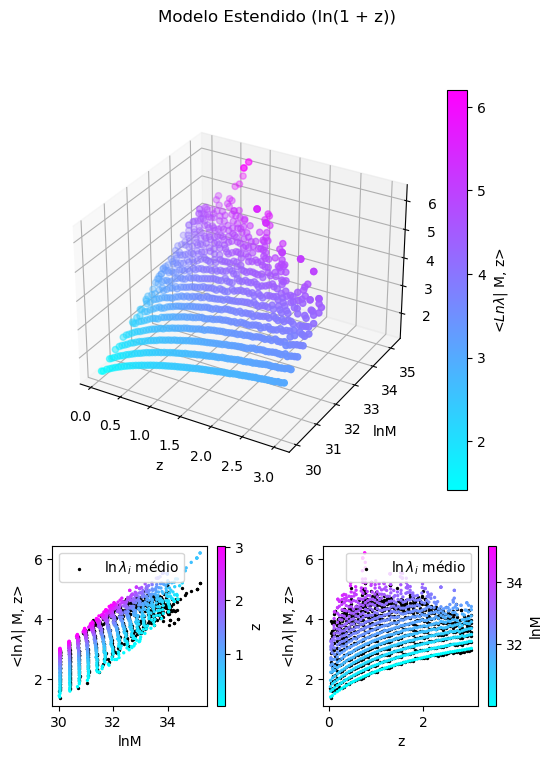

In [11]:
#Plot_model(lnR_mean_ascaso, data_train) #Ascaso
Plot_model(lnR_mean_ext_ln1pz, data_train) #Extended (ln(1 + z)) 
#Plot_model(lnR_mean_ext_z, data_train)

plt.show()

In [12]:
def Plot_model_std(lnR_std_model, data_set):

    fig = plt.figure(figsize=(6,8))
    gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[2.5, 1], wspace=0.4)
   
    ax1 = fig.add_subplot(gs[0, :], projection='3d')
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    #lnR model, z_mean, y_mean
    halos_mean = bin_meanf(data_set)[0]
    std_mean = bin_meanf(data_set)[4]
    
    xs = halos_mean["redshift_true"]
    ys = np.log(halos_mean["m200c"])
    zs = lnR_std_model
    
    p1 =ax1.scatter(xs, ys, zs, c=zs, cmap='cool')
    ax1.set_xlabel('z')
    ax1.set_ylabel('lnM')
    fig.colorbar(p1, ax=ax1, label='$\sigma_{\ln \lambda}$')

    ax2.scatter(ys, std_mean, c='k',s=2.0, label='$\sigma^{i}$')
    p2 = ax2.scatter(ys, zs , c= xs,s=2.0, cmap='cool')
    ax2.set_xlabel('lnM')
    ax2.set_ylabel('$\sigma_{\ln \lambda}$')
    fig.colorbar(p2, ax=ax2, label='z')
    ax2.set_yscale('log')
    ax2.legend()

    ax3.scatter(xs, std_mean, c='k',s=2.0, label='$\sigma^{i}$')
    p3 = ax3.scatter(xs, zs , c=ys,s=2.0, cmap='cool') 
    ax3.set_xlabel('z')
    ax3.set_ylabel('$\sigma_{\ln \lambda}$')
    fig.colorbar(p3, ax=ax3, label='lnM')
    ax3.legend()

    
    if f'{lnR_std_model}' == f'{lnR_std_ascaso}': 
        fig.suptitle('Modelo de Ascaso', size=16)
    elif f'{lnR_std_model}' == f'{lnR_std_ext_ln1pz}': 
        fig.suptitle('Modelo Estendido (ln(1 + z))', size=16)
    elif f'{lnR_std_model}' == f'{lnR_std_ext_z}': 
        fig.suptitle('Modelo Estendido (z)', size=16)
    else: 
        pass
        
    plt.show()

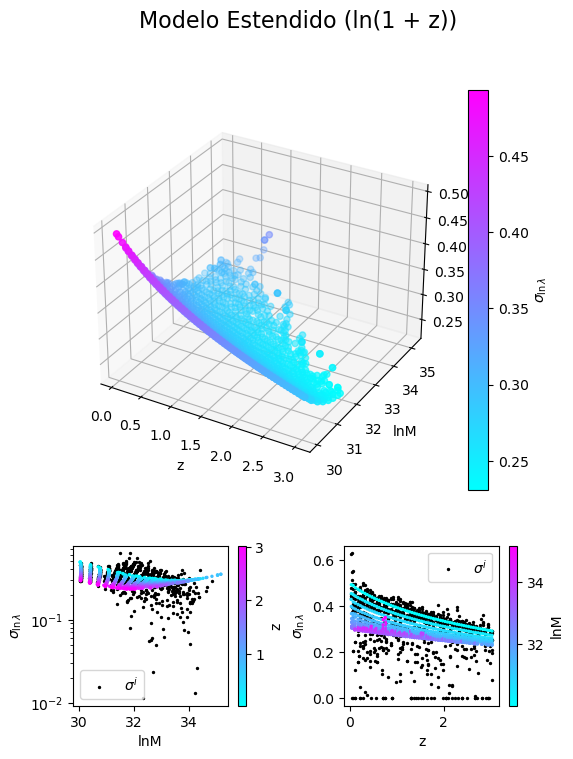

In [13]:
#Plot_model_std(lnR_std_ascaso, data_train) #Ascaso
Plot_model_std(lnR_std_ext_ln1pz, data_train) #Extended (ln(1 + z)) 
#Plot_model_std(lnR_std_ext_z, data_train)

plt.show()

## Cross Validation

- Relative error:

\begin{equation}
Rel\_err = \frac{\left<\ln R_i | M_i, z_i \right> - {\mu^{i}}_{lnR}}{{\mu^{i}}_{lnR}}
\end{equation}

- Mean Square Error (MSE):

\begin{equation}
MSE = \frac{1}{N} \sum^{N} ({\mu^{i}}_{lnR} - \left<\ln R_i | M_i, z_i \right> )^2
\end{equation}

- Root Mean Square Error (RMSE):

\begin{equation}
RMSE = \sqrt{MSE}
\end{equation}


In [14]:
bin_f= bin_meanf(data_test)

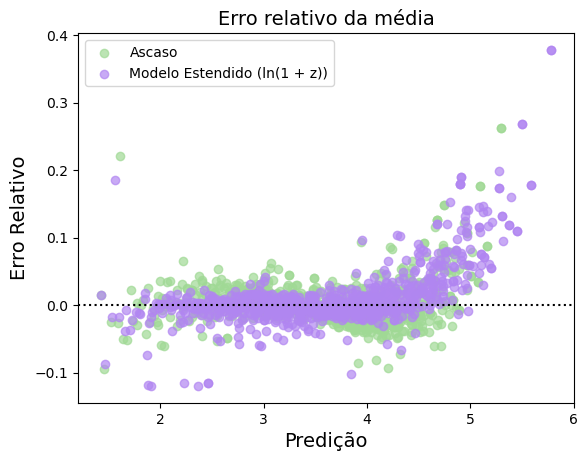

In [15]:
# MEAN 
halos_mean = bin_f[0]

lnR_test = np.log(halos_mean["richness"])
lnM_test = np.log(halos_mean["m200c"])
z_test = halos_mean["redshift_true"]

ascaso_mean_valid = np.array( [ascaso.get_mean_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test))])
ext_ln1pz_mean_valid = np.array([ext_ln1pz.get_mean_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test))])

#Relative Error: mean
plt.scatter(ascaso_mean_valid, (ascaso_mean_valid - lnR_test)/ lnR_test, c='#a0d995', alpha=0.7, label='Ascaso')
plt.scatter(ext_ln1pz_mean_valid, (ext_ln1pz_mean_valid - lnR_test)/ lnR_test, c='#b186f1', alpha=0.7, label='Modelo Estendido (ln(1 + z))')
plt.xlabel('Predição', size=14)
plt.ylabel('Erro Relativo', size=14)
# plt.yscale('log')
plt.axhline(y=0.0, color='black', linestyle='dotted')

plt.title('Erro relativo da média', size=14)
plt.legend()
plt.show()

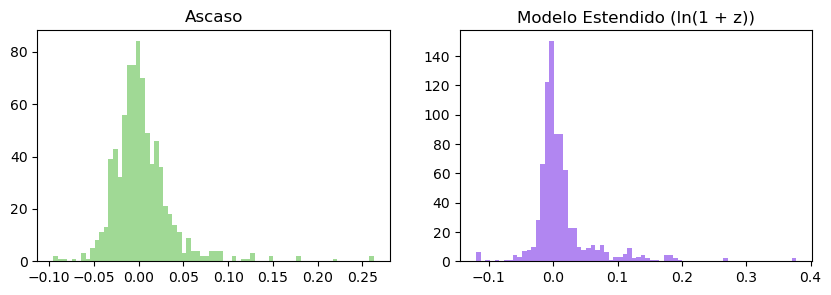

1.0132397258119034e-10
4.1118928473686054e-35


In [16]:
fig = plt.figure(figsize=(10,3))
ax1=plt.subplot(121)
ax2=plt.subplot(122)

Rel_as = (ascaso_mean_valid - lnR_test) / lnR_test
Rel_ex = (ext_ln1pz_mean_valid - lnR_test) / lnR_test

ax1.hist(Rel_as, bins=70, color='#a0d995')
ax1.set_title('Ascaso')

ax2.hist(Rel_ex, bins=70, color='#b186f1')
ax2.set_title('Modelo Estendido (ln(1 + z))')

plt.show()


print(stats.kstest(Rel_as, stats.norm.cdf, args=(np.mean(Rel_as), np.std(Rel_as))).pvalue)
print(stats.kstest(Rel_ex, stats.norm.cdf, args=(np.mean(Rel_ex), np.std(Rel_ex))).pvalue)

In [17]:
MSE_ascaso = sum((lnR_test - ascaso_mean_valid) ** 2) / len(ascaso_mean_valid)
RMSE_ascaso = np.sqrt(MSE_ascaso)

MSE_ext_ln1pz = sum((lnR_test - ext_ln1pz_mean_valid) ** 2) / len(ext_ln1pz_mean_valid)
RMSE_ext_ln1pz = np.sqrt(MSE_ext_ln1pz )

print(MSE_ascaso, RMSE_ascaso)
print(MSE_ext_ln1pz, RMSE_ext_ln1pz)

0.018312358969561824 0.13532316494067756
0.040177947833379454 0.20044437590857833


In [18]:
from sklearn.metrics import mean_absolute_percentage_error

print(mean_absolute_percentage_error(lnR_test, ascaso_mean_valid) * 100) 
print(mean_absolute_percentage_error(lnR_test, ext_ln1pz_mean_valid) * 100) 

2.1950851546430816
2.5782682856640697


In [19]:
bin_f= bin_meanf(data_test)
lnR_test_std = bin_f[4]

ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])

In [20]:
MSE_ascaso_std = sum((lnR_test_std - ascaso_std_valid) ** 2) / len(ascaso_std_valid)
RMSE_ascaso_std = np.sqrt(MSE_ascaso_std)

MSE_ext_ln1pz_std = sum((lnR_test_std - ext_ln1pz_std_valid) ** 2) / len(ext_ln1pz_std_valid)
RMSE_ext_ln1pz_std = np.sqrt(MSE_ext_ln1pz_std )

print(f"Std Erros\n\nAscaso: \tMSE: {MSE_ascaso_std: .3f},\t RMSE:{RMSE_ascaso_std: .3f}")
print(f"Extended:\tMSE: {MSE_ext_ln1pz_std: .3f},\t RMSE:{RMSE_ext_ln1pz_std: .3f}\n")

Std Erros

Ascaso: 	MSE:  0.008,	 RMSE: 0.092
Extended:	MSE:  0.012,	 RMSE: 0.110



/tmp/ipykernel_1813089/1138155046.py:3: RuntimeWarning: divide by zero encountered in divide
  a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
/tmp/ipykernel_1813089/1138155046.py:4: RuntimeWarning: divide by zero encountered in divide
  e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std


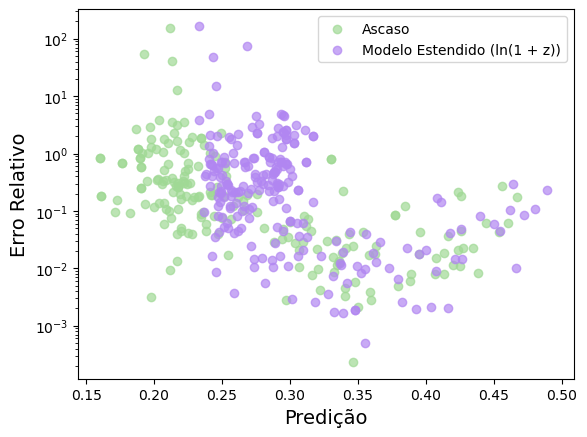

In [24]:
# STD 
#Relative Error: std
a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std

# #CUT 1
# cut =np.abs(a_err) < 1000
# a_err = a_err[cut]
# ascaso_std_valid2 = ascaso_std_valid[cut]
# lnR_test_std1 = lnR_test_std[cut]

# #CUT 2
# cut2 = np.abs(e_err) < 1000
# lnR_test_std2 = lnR_test_std[cut2]
# e_err = e_err[cut2]
# ext_ln1pz_std_valid2 = ext_ln1pz_std_valid[cut2]

#Plot
plt.scatter(ascaso_std_valid, a_err, c='#a0d995', alpha=0.7, label='Ascaso')
plt.scatter(ext_ln1pz_std_valid, e_err, c='#b186f1', alpha=0.7, label='Modelo Estendido (ln(1 + z))')

plt.xlabel('Predição', size=14)
plt.ylabel('Erro Relativo', size=14)
plt.axhline(y=0.0, color='black', linestyle='dotted')
#plt.title('Erro relativo do desvio padrão (< 10)', size=16)
plt.yscale('log')
plt.legend()
plt.show()

# print(f"MAPE:STD\n\nMAPE (Ascaso): {mean_absolute_percentage_error(lnR_test_std1, ascaso_std_valid2) * 100: .2f}%") 
# print(f"MAPE (Extended): {mean_absolute_percentage_error(lnR_test_std2, ext_ln1pz_std_valid2) * 100: .2f}%") 

In [25]:
lnR_test_std = bin_f[4]
ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])

a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std

cut =np.abs(a_err) < 300.0
a_err = a_err[cut]
ascaso_std_valid = ascaso_std_valid[cut]
lnR_test_std = lnR_test_std[cut]

MSE_ascaso_std = sum((ascaso_std_valid - lnR_test_std) ** 2) / len(ascaso_std_valid)
RMSE_ascaso_std = np.sqrt(MSE_ascaso_std)

lnR_test_std = bin_f[4]
cut2 = np.abs(e_err) < 300.0
e_err = e_err[cut2]
ext_ln1pz_std_valid = ext_ln1pz_std_valid[cut2]
lnR_test_std = lnR_test_std[cut2]

MSE_ext_ln1pz_std = sum((ext_ln1pz_std_valid - lnR_test_std) ** 2) / len(ext_ln1pz_std_valid)
RMSE_ext_ln1pz_std = np.sqrt(MSE_ext_ln1pz_std )

print(MSE_ascaso_std, RMSE_ascaso_std)
print(MSE_ext_ln1pz_std, RMSE_ext_ln1pz_std)

0.005648177978708812 0.0751543610092509
0.007272280215236494 0.08527766539508744


/tmp/ipykernel_1813089/3820996510.py:5: RuntimeWarning: divide by zero encountered in divide
  a_err = (ascaso_std_valid - lnR_test_std)/ lnR_test_std
/tmp/ipykernel_1813089/3820996510.py:6: RuntimeWarning: divide by zero encountered in divide
  e_err = (ext_ln1pz_std_valid - lnR_test_std)/ lnR_test_std


In [26]:
bin_f= bin_meanf(data_test)
lnR_test_std = bin_f[4]

ascaso_std_valid = np.array([ascaso.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])
ext_ln1pz_std_valid = np.array([ext_ln1pz.get_std_richness(lnM_test[i], z_test[i]) for i in range(len(lnR_test_std))])